# Euler with ExaHyPE 2 
 
A very simple example which demonstrates how to configure a patch-based Finite Volume solver in Peano 4 through the ExaHyPE 2 interface/API. The solver simulates the simple Euler equations, i.e. we rely on the abstract first-order hyperbolic expression

$ \partial Q + \nabla ^T \cdot F(Q) = 0$

In this particular case, this formulation is


$ \frac{\partial}{\partial t} \begin{pmatrix}
\rho\\j\\\ E
\end{pmatrix}
+
\nabla\cdot\begin{pmatrix}
{j}\\
\frac{1}{\rho}j\otimes j + p I \\
\frac{1}{\rho}j\,(E + p)
\end{pmatrix}
= 0
 $ 






To startup ExaHyPE, we need a couple of imports. To make them work, you will have to set your environment variables correctly before you launch the notebook or Python script respectively. On a standard checkout, this is

export PYTHONPATH=../../../python

or

export JUPYTER_PATH=../../../python

respectively. If you run the notebook locally, you might have to set both pathes. If you prefer to run this example without the browser (might be faster), use the ipython3 command:





In [1]:
import os
import peano4
import exahype2

DaStGen 2 (C) www.peano-framework.org
Peano 4 (C) www.peano-framework.org
ExaHyPE 2 (C) www.peano-framework.org


I first cleanup some local files. Would be a pity to become confused through a lot of output from a previous run.

In [2]:
output_files = [ f for f in os.listdir(".") if f.endswith(".peano-patch-file") or f.endswith(".vtu") ]
for f in output_files:
  os.remove(f)

The first thing to do in any ExaHyPE 2 application is to create an ExaHyPE project. We have to tell it exactly what namespace we want to use (it is examples::exahype2::euler here), we have to give it a name. There are a few more options that we omit here.

In [3]:
project = exahype2.Project( ["examples", "exahype2", "euler"], "finitevolumes" )

## A Finite Volumes solver

Our first step is to use a Finite Volumes solver. So we add this solver to the project. An ExaHyPE mesh can carry multiple solvers at the same time, but we only use one here.

In [4]:
patch_size     = 11
unknowns       = 5
time_step_size = 0.0001
max_h          = 0.1
min_h          = 0.1
project.add_solver(  exahype2.solvers.GenericRusanovFVFixedTimeStepSize("Euler", patch_size, unknowns, min_h, max_h, 0.0001) )

## Configure the global domain

We next configure our global domain, i.e. we specify the dimensions of the computational domain $\Omega $, we specify how long the simulation shall run and how often we want it to dump its data. The dumps will later be used to produce screenshots of the data (or to extract all kinds of properties).

In [5]:
dimensions = 2

if dimensions==2:
  project.set_global_simulation_parameters(
    dimensions,  [0.0,0.0],  [1.0,1.0],
    0.005,        # end time
    0.0, 0.001    # snapshots
  )
else:
  project.set_global_simulation_parameters(
    dimensions, [0.0,0.0,0.0], [1.0,1.0,1.0],
    0.005,         # end time
    0.0, 0.001     # snapshots
  )


## Generate a Peano 4 project

ExaHyPE's Python API does not really "do" something itself. It is a front-end to create and configure a Peano project. Peano in turn has its own Python API. In principle that allows us to use ExaHyPE 2 as a very high level code generator that we later on tweak. We can even use the outcome to inject further functionality that has never been supported by ExaHyPE 2 yet is available in Peano.

For the time being, none of these things is requires. We therefore simply ask ExaHyPE's API to give us a Peano project. This project is then told to generate the "real" C++ code and to translate. Every system will have a bespoke configuration, i.e. its own set of compilers, include paths, ... All of these ingredients have been chosen and tailored when we issued the configure script. Peano's Python API can parse the outcome of the configure instruction and use the same settings for the ExaHyPE/Peano project, too.

The generation can build up reasonably big data structures. If you work on a low-spec machine, you thus might want to tell the generate command to throw away all generated data after the C++ code has been built up.

In [6]:
build_mode = peano4.output.CompileMode.Asserts
project.set_Peano4_installation("../../..", build_mode)

peano4_project = project.generate_Peano4_project()

parse configure outcome ../../../src/Makefile to extract compile settings
used C++ compiler is mpiicpc
used Fortran compiler is ifort


In [7]:
peano4_project.generate( throw_away_data_after_generation=False )

generate all code ...
some artefacts have already been added to repository ... assume this is intentional (by higher abstraction layer, e.g.)
generated finitevolumes-main.cpp
write ./Makefile
write ././AbstractEuler.h (generated from template /home/tobias/git/Peano/python/exahype2/solvers/GenericRusanovFVFixedTimeStepSizeAbstract.template.h)
write ././AbstractEuler.cpp (generated from template /home/tobias/git/Peano/python/exahype2/solvers/GenericRusanovFVFixedTimeStepSizeAbstract.template.cpp)
write ./observers/SolverRepository.h (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.h)
write ./observers/SolverRepository.cpp (generated from template /home/tobias/git/Peano/python/exahype2/ProjectSolverRepository.template.cpp)
write ./celldata/EulerQ.h (generated from template /home/tobias/git/Peano/python/peano4/datamodel/PatchToDoubleArray.h.template)
write ./celldata/EulerQ.cpp (generated from template /home/tobias/git/Peano/python/peano4/dat

With all project content generated, we can finally translate the code. Note that the above steps have actually produced a Makefile in our ExaHyPE 2 project folder. So we can either translate the project through the notebook, or we can switch to a terminal and invoke the translation manually.

Take care with the translation process if you want to use something fancy that is not active by default. If you have particular modules loaded or environment variables set, then all of these are required before you launch the notebook. On my own system, I need for example

<pre>
source /opt/intel/bin/iccvars.sh intel64
source /opt/intel/itac/2020.0.015/bin/itacvars.sh
source /opt/intel/impi/2019.6.166/intel64/bin/mpivars.sh
</pre>

to use the Intel toolchain. I experienced issues with notebooks where compile errors had not been displayed. Have a look at the terminal: It seems that cerr is not always piped into the notebook window. If that doesn't help, the only remaining option is to execute the whole notebook via ipython3.

In [ ]:
parallel_builds = 1   # I don't use a massively parallel build here as my laptop otherwise becomes too hot.
                      # Without any arguments, the build process will grab all of your cores.
peano4_project.build( make_clean_first = True, number_of_parallel_builds = parallel_builds )

clean up project ...
clean complete
start to compile with concurrency level of 1...


## Run the code and postprocess results

Once we have the Peano 4 project set up and built, we obtain an executable which is standalone. It comprises all the parameters we have set above. So we can either invoke this file on the command line or we can call it through the notebook. Depending on your setup you might want to call the code with a prefix. If you configured Peano with MPI, e.g., you might have to use the mpirun prefix. 

Please note that we pipe the terminal output into a file. This way, we can postprocess the data in the next step.

In [8]:
peano4_project.run( [], prefix = ["mpirun", "-n", "1"], pipefile = "output.txt", rebuild_if_required=False )

run application ...
run complete


True

We first get the data from the output file. This is ExaHyPE 2 specific (though application-generic), so we rely on ExaHyPE's postprocessing routines.



In [9]:
import exahype2

performance_data = exahype2.postprocessing.PerformanceData( "output.txt", verbose=True )

triggered plot at 19.0s
started new time step at 21.0s
started new time step at 33.0s
started new time step at 46.0s
started new time step at 57.0s
started new time step at 70.0s
started new time step at 83.0s
started new time step at 95.0s
started new time step at 106.0s
started new time step at 117.0s
started new time step at 130.0s
triggered plot at 142.0s
started new time step at 144.0s
started new time step at 156.0s
started new time step at 168.0s
started new time step at 180.0s
started new time step at 192.0s
started new time step at 205.0s
started new time step at 216.0s
started new time step at 228.0s
started new time step at 239.0s
started new time step at 251.0s
triggered plot at 262.0s
started new time step at 264.0s
started new time step at 275.0s
started new time step at 288.0s
started new time step at 300.0s
started new time step at 312.0s
started new time step at 324.0s
started new time step at 335.0s
started new time step at 348.0s
started new time step at 360.0s
start

In this worksheet, I'd like to have interactive matplotlib plots: You might need the statement

<pre>
%matplotlib widget
</pre>

but on my local notebook server, this causes a crash.

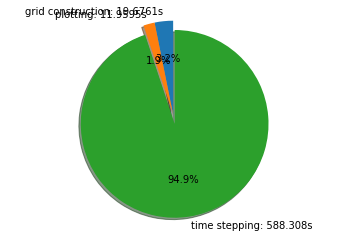

In [10]:
exahype2.postprocessing.plot_pie_chart_over_simulation_phases(performance_data)

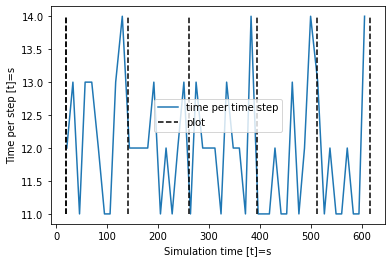

In [11]:
exahype2.postprocessing.plot_time_per_time_step(performance_data)

## Working with a symbolic flux function

This part yet is to be written

## Parallelisation

The parallelisation in ExaHyPE 2 is relatively simple. 

- You have to ensure that configure is called with multithreading and/or MPI support. I recommend never to run MPI without multicore parallelisation. Once you have configured it appropriately, please rebuild all libraries.
- You next have to add a load balancing to your Python project. This will then tell your application to exploit all resources. My default load balancing usually a good starting point. 

In [2]:
load_balancing_quality = 0.9  # quantifies computational ill-balance that we are happy accept
project.set_load_balancing( "toolbox::loadbalancing::RecursiveSubdivision", "(" + str(load_balancing_quality) + ")" )

NameError: name 'project' is not defined

We now have to rebuild the application and then rerun the code:

In [1]:
peano4_project = project.generate_Peano4_project()
peano4_project.generate( throw_away_data_after_generation=False )


NameError: name 'project' is not defined

In [ ]:
peano4_project.build( make_clean_first = True, number_of_parallel_builds = parallel_builds )